# Transition path theory tutorial

***This notebook is not complete!***

In this tutorial, we will introduce and illustrate some basic ideas behind **transition path theory (TPT)**, which is used to compute statistics on *ensembles* of reactive trajectories (which we will call **transitions**) between macrostates in the state space. We will need the following Julia packages:

In [2]:
using LinearAlgebra, ApproxFun
using Random, DifferentialEquations
using Plots, LaTeXStrings

We might also use this propagator operation from the operator exponential [tutorial](https://github.com/mjyshin/math-tutorials/blob/main/operator_exponential.ipynb). (We pick this one instead of the [alternative](https://github.com/mjyshin/math-tutorials/blob/main/alternate_exponential.ipynb), since our operators are not self-adjoint.)

In [3]:
import Base: exp

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    C = Conversion(domainspace(L),rangespace(L))
    
    perm = [3;2;1;4:n]
    P = I(n)[:,perm]    # permutation matrix
    
    B = B[1:2,1:n]*P    # permuted BCs
    B = B[1:2,1:2]\B    # Gaussian eliminated BCs
    M = C[1:n-2,1:n]*P    # permuted masses
    M = M - M[:,1:2]*B    # remove d.o.f.
    L = L[1:n-2,1:n]*P    # permuted generator
    L = L - L[:,1:2]*B    # remove d.o.f.
    A = M[:,3:n]\L[1:n-2,3:n]    # BC-merged generator
    
    c = P'*u0.coefficients[1:n]    # permuted coeffs
    c0 = exp(A*t)*c[3:n]    # interior coeffs, Eq. (3)
    ∂c = B*c - B[:,3:n]*c0    # BC coeffs
    
    c = P*[∂c;c0]    # de-permuted coeffs
    u = chop(Fun(domain(u0),c))
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 39 methods)

Before we venture into the nomenclature of ₊, we should review some useful notions from stochastic processes in 1D, namely the forward and backward generators of the process (as we will use them quite a bit).

## Background on stochastic processes

We define a one-parameter semigroup of operators (called the **Markov semigroup**) on an arbitrary *bounded* observable $f$ on the stochastic process $X_t\in\Omega:=\mathbb{R}$ (this is sloppy notation) as the conditional expectation

$$
(T_tf)(x) := \mathbb{E}[f(X_t)\vert X_0 = x]
$$

with the identity $I=T_0$ and the infinitesimal generator of $T_t$

$$
\mathcal{L}f := \lim_{t\to 0^+}\frac{T_tf - f}{t}.
$$

If we define a time dependent function $u(x,t) := (T_tf)(x)$, we can easily derive that $u$ observes the PDE (called the **backward Kolmogorov equation (BKE)**)

$$
\begin{align}
\frac{\partial u}{\partial t} &= \mathcal{L}u\\
u(x,0) &= f(x)
\end{align}\label{eq:bke}\tag{1}
$$

by using the chain rule and the fact that $T_t = e^{t\mathcal{L}}$ by the general property of semigroups of operators. We can therefore think of the KBE as the dynamics of arbitrary *moments* of the process $X_t$. If we expand $u(x,t) = \int_\Omega f(x)\rho(x,t)\,\text{d}x$ and apply $T_t$ to $f$ we get

$$
\int_\Omega(T_tf)(x)\rho(x,t)\,\text{d}x = \int_\Omega f(x)(T_t^\ast\rho)(x,t)\,\text{d}x,
$$

where $T_t^\ast$ is the formal adjoint of $T_t$ with generator $\mathcal{L}^\ast$ (which is the adjoint of $\mathcal{L}$) that observes the PDE (called the **forward Kolmogorov equation (FKE)**) on the probability density $\rho$ of the process $X_t$:

$$
\begin{align}
\frac{\partial\rho}{\partial t} &= \mathcal{L}^\ast\rho\\
\rho(x,0) &= \rho_0(x),
\end{align}\label{eq:fke}\tag{2}
$$

given some initial density $\rho_0$. For a (time-)homogeneous diffusion process with drift, the above FKE is the famous **Fokker-Planck equation (FPE)** where we have the functional form

$$
\mathcal{L}^\ast = -\frac{\partial}{\partial x}\left(\mu(x)\,\cdot\right) + \frac{1}{2}\frac{\partial^2}{\partial x^2}\left(\sigma(x)^2\,\cdot\right).
$$

Using integration by parts on $\langle f,\mathcal{L}^\ast\rho \rangle = \langle \mathcal{L}f,\rho \rangle$ (and the fact that $f$ is bounded, therefore disappearing on $\partial\Omega$), we arrive at the functional form of the KBE for the diffusion process with drift:

$$
\mathcal{L} = \mu(x)\frac{\partial}{\partial x} + \frac{1}{2}\sigma(x)^2\frac{\partial^2}{\partial x^2}.
$$

### Mathematical model

Let's illustrate this with a simple case of overdamped dynamics on a double-well potential and constant noise

$$
\mu(x) := -V'(x),\quad \sigma(x) := \sqrt{2D},
$$

where $V(x) = \frac{1}{\epsilon}\left(\frac{x^4}{4} - \frac{x^2}{2} - \alpha x\right)$ is the potential function and $D$ is the diffusion constant. We'll let $\epsilon=0.1$ and $\alpha=0.1$ for concreteness. Let's visualize $V$, noting that it does not depend on $D$:

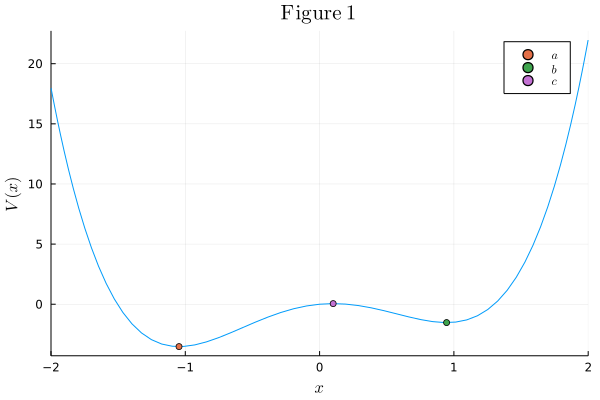

In [118]:
ϵ,α = 0.1,0.1
xmin,xmax = -2,2
Ω = Chebyshev(xmin..xmax)
V = Fun(x->(x^4/4 - x^2/2 + α*x)/ϵ,Ω)
a,c,b = roots(V')

fig1 = plot(V,xlims=(xmin,xmax),title=L"\textrm{Figure\ 1}",label=false)
fig1 = scatter!([a],[V(a)],label=L"a",xlabel=L"x")
fig1 = scatter!([b],[V(b)],label=L"b",ylabel=L"V(x)")
fig1 = scatter!([c],[V(c)],label=L"c",fmt=:png)
display(fig1)

From Fig. 1, we can imagine that the process $X_t$ would jump between the two wells (called **metastable states**) centered around $x=a\approx-1$ and $x=b\approx1$ due to the diffusive noise, but generally spend more time in the former well due to its lower energy (unless the noise absolutely dominates the dynamics). To see this more clearly, let's simulate one such trajectory of $X_t$.

The corresponding SDE for this process is

$$
\text{d}X_t = \underbrace{-V'(X_t)}_{f(X_t,t)}\,\text{d}t + \underbrace{\sqrt{2D}}_{g(X_t,t)}\,\text{d}W_t,\label{eq:sde}\tag{3}
$$

where $W_t$ is the standard Wiener process with $\text{d}W_t \sim \mathcal{N}(0,\text{d}t)$.

In [100]:
f(x,θ,t) = -(x^3 - x + θ.α)/θ.ϵ
g(x,θ,t) = √(2θ.D)

g (generic function with 1 method)

We'll also set the diffusion at $D=2$ and run the SDE in $\mathbb{T}=[0,100]$ from $X_0=0$.

In [101]:
D = 2
θ = (ϵ=ϵ,α=α,D=D)
tspan = (0.0,100.0)
x0 = 0

0

We can sample from Eq. ([3](#mjx-eqn-eq:sde)) and plot it as a function of time:

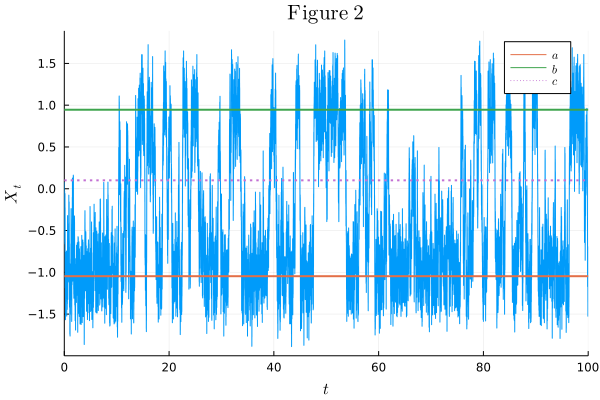

In [102]:
Random.seed!(1234)
prob = SDEProblem(f,g,x0,tspan,θ)
x = solve(prob)

fig2 = plot(x,xlabel=L"t",ylabel=L"X_t",title=L"\textrm{Figure\ 2}",label=false,fmt=:png)
fig2 = hline!([a],width=2,label=L"a")
fig2 = hline!([b],width=2,label=L"b")
fig2 = hline!([c],width=2,style=:dot,label=L"c")
display(fig2)

Just as we intuitively predicted, $X_t$ seems to "prefer" the left well around $x=a$.

## Introduction to transition path theory

As we introduced in the very beginning, TPT is a formalism to compute useful statistics on "transitions", which we will now formally define. There are lots of terms, so try not to get too flustered if it's a bit confusing at first!

The first question we ask is: *Where is this transition to and from?* To answer this, we will define two macrostates in $\Omega$ to the left of the left well and to the right of the right well in Fig 1.

$$
A := \{x\in\Omega:x\leq a\},\quad B := \{x\in\Omega\setminus A:x\geq b\},
$$

as well as two functions on $\mathbb{T}$ denoting *when $X_t$ was last at $A$/$B$* and *when $X_t$ will next be at $A$/$B$*:

$$
\tau_0(t) := \sup\{\tau\leq t:X_\tau\in A\cup B\},\quad \tau_f(t) := \inf\{\tau\geq t:T_\tau\in A\cup B\}.
$$

Note that if $X_t\in A\cup B$, then $\tau_0(t)=\tau_f(t)=t$. Finally, we also define a **reaction** (or "reactive trajectory" or "transition") to be a path that *begins at $A$* and *ends at $B$*. Then we can call

$$
\mathcal{X}_R := \{X_t\in\Omega\setminus(A\cup B):t\in \mathbb{T}_R\}
$$

the *ensemble* of reactive trajectories, where

$$\mathbb{T}_R := \{t\in\mathbb{T}:X_{\tau_0(t)}\in A,X_{\tau_f(t)}\in B\}$$

is the set of times that $X_t$ is undergoing a reaction. (In layman's term, the first condition simply says $X_t$ came from $A$, and the second condition that $X_t$ is going to $B$.) By this definition, trajectories that *don't* count as transitions are those that go from $A$ to $A$, from $B$ to $B$, and from $B$ to $A$.

Now that we have that out of the way, let's briefly introduce three statistics we can compute on $\mathcal{X}_R$:

- Reactive trajectory $\pi_R$, describing the equilibrium density of $X_t\in\mathcal{X}_R$,
- Reactive flux $\textbf{j}_R$, describing the current/flow through a dividing surface out of $A$ towards $B$, and
- Reaction rate $r_R$, describing how "quickly" a typical transition takes place.

In order to compute these, however, we need three auxiliary functions: the equilibrium density $\pi$, forward committor $q_+$, and backward committor $q_-$. In the next six subsections, we will go over the definitions of and compute these six functions.

### Equilibrium density

As stated above, the probability density of the process $X_t$ follows the FKE ([2](#mjx-eqn-ex:fke)). Let's get the adjoint generator in a friendlier form for numerical computation. Using the chain rule, we get

$$
\begin{align*}
\mathcal{L}^\ast &= \frac{\partial}{\partial x}\left(V'(x)\,\cdot\right) + D\frac{\partial^2}{\partial x^2}\\
&= V''(x) + V'(x)\frac{\partial}{\partial x} + D\frac{\partial^2}{\partial x^2}.
\end{align*}
$$

The BCs are $\rho(x,t)\xrightarrow{x\to\pm\infty}0$ as we have the normalization constraint $\int_\Omega\rho(x,t)\,\text{d}x=1$, but since the potential $V(x)$ is already pretty high at $\lvert x \rvert>2$, we will set Dirichlet BCs at those "numerical boundaries".

In [103]:
𝒟x = Derivative(Ω)
ℒᵀ = V'' + V'*𝒟x + D*𝒟x^2
ℬ = [ldirichlet(Ω);rdirichlet(Ω)]
∑ = DefiniteIntegral(Ω)
μ,σ = 0,0.5
ρ0 = Fun(x->1/√(2π*σ^2)*exp(-(x-μ)^2/(2σ^2)),Ω)

Fun(Chebyshev(-2..2),[0.16516363700114997, 0.0, -0.2852450701390882, 0.0, 0.18770473893275585, 0.0, -0.09754033120633235, 0.0, 0.041394242123257326, 0.0  …  0.0, 1.4755281862849331e-12, 0.0, -1.5371685739927202e-13, 0.0, 1.522613686079408e-14, 0.0, -1.4481681006350594e-15, 0.0, 1.307480057381738e-16])



$$
\begin{align*}
\mathcal{L}^\ast\pi &= 0,\quad x\in\Omega\\
\pi(x) &= 0,\quad x\in\partial\Omega\\
\int_\Omega\pi(x)\,\text{d}x &= 1
\end{align*}
$$

The analytical solution to the above

$$
\pi(x) = Z^{-1}e^{-\frac{V(x)}{D}},
$$

where $Z = \int_\Omega\pi(x)\,\text{d}x$ is the partition function

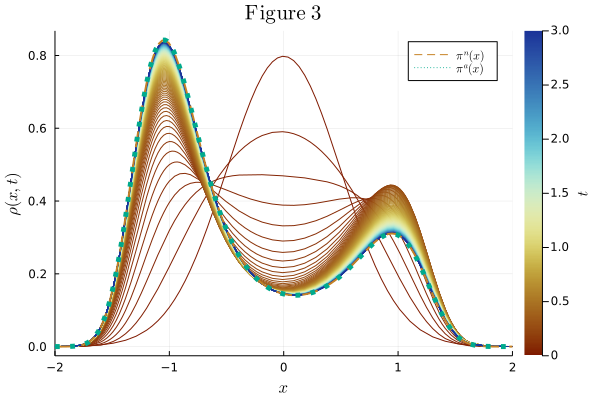

In [104]:
t = 0:0.02:3
ρ = exp.(Ref(ℒᵀ),Ref(ℬ),t,Ref(ρ0))    # PDE solution
#πⁿ = [∑;ℬ;ℒᵀ]\[1;0;0;0]    # computationally very expensive
πⁿ = [ℬ;ℒᵀ]\[eps();eps();0]    # numerical approximation
πⁿ = πⁿ/sum(πⁿ)    # normalization constraint
πᵃ = exp(-V/D)/sum(exp(-V/D))    # analytical solution

fig3 = plot(xlims=(xmin,xmax),xlabel=L"x",ylabel=L"\rho(x,t)",title=L"\textrm{Figure\ 3}")
fig3 = plot!(ρ,line_z=t',color=:roma,cbar=true,cbartitle=L"t",label=false,fmt=:png)
fig3 = plot!(πⁿ,width=2,style=:dash,label=L"\pi^n(x)")
fig3 = plot!(πᵃ,width=5,style=:dot,label=L"\pi^a(x)")
display(fig3)

What does this tell us? The equilibrium density $\pi$ is the 

### Forward committor

In [120]:
Ωᴿ = Chebyshev(a..b)
Vᴿ = Fun(x->(x^4/4 - x^2/2 + α*x)/ϵ,Ωᴿ)
𝒟xᴿ = Derivative(Ωᴿ)
ℒ = -Vᴿ'*𝒟xᴿ + D*𝒟xᴿ^2
ℬᴿ = [ldirichlet(Ωᴿ);rdirichlet(Ωᴿ)]

InterlaceOperator : Chebyshev(-1.0466805318046002..0.9456492739235907) → 2-element ArraySpace:
ConstantSpace{DomainSets.Point{Float64}, Float64}[ConstantSpace(Point(-1.0466805318046002)), ConstantSpace(Point(0.9456492739235907))]
 1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  ⋯
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  ⋯

$$
\begin{align*}
\mathcal{L}q_+ &= 0,\quad x\in\Omega\setminus(A\cup B)\\
q_+(x) &= 0,\quad x\in\partial A\\
q_+(x) &= 1,\quad x\in\partial B
\end{align*}
$$

The analytical quadrature solution to the equation above is

$$
q_+(x) = C^{-1}\int_a^xe^{\frac{V(\xi)}{D}}\,\text{d}\xi,
$$

where $C = \int_a^be^{\frac{V(\xi)}{D}}\,\text{d}\xi$ is the normalizing constant for the total probability.

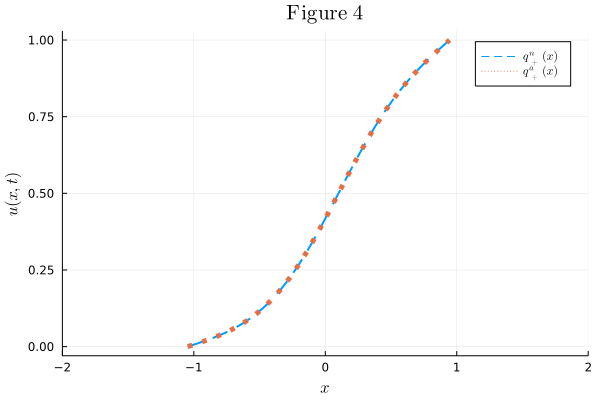

In [128]:
#u0 = Fun(x->(tanh(10^1*(x-b)) + 1)/2,Ωᴿ)
#=u0 = Fun(x->(x*(x-a)*(x-b) + (x-a))/2,Ωᴿ)
t = 0:0.1:1
u = exp.(Ref(ℒ),Ref(ℬᴿ),t,Ref(u0))=#

q₊ⁿ = [ℬᴿ;ℒ]\[0;1;0]
q₊ᵃ = cumsum(exp(Vᴿ/D))/sum(exp(Vᴿ/D))

fig4 = plot(xlims=(xmin,xmax),xlabel=L"x",ylabel=L"u(x,t)",title=L"\textrm{Figure\ 4}")
#fig4 = plot!(u,line_z=t',color=:roma,cbar=true,cbartitle=L"t",label=false)
fig4 = plot!(q₊ⁿ,width=2,style=:dash,label=L"q_+^n(x)")
fig4 = plot!(q₊ᵃ,width=5,style=:dot,label=L"q_+^a(x)",fmt=:png)
display(fig4)

### Backward committor